In [20]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

import gaccord as accord
from gaccord import GraphicalAccord
from utils import partial_corr, compute_tp_fp, mcc, precision_recall, sensitivity_specificity, pseudo_BIC, proj_precision_mat
from generate_graphs import generate_erdos_renyi, generate_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Hub Network

In [8]:
Partial_corr = np.genfromtxt('hub-network.txt', delimiter=',')
Skel = np.where(Partial_corr != 0, 1, 0)

n, p = 500, 1000
n_prop_to_p = [0.5]
random_state = 2023
lower_weight, upper_weight = 0.5, 1.0
spread_diag=[1, np.sqrt(3)]

# projection method
np.random.seed(random_state)
edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
edge_signs = np.random.choice([-1,1], size=(p,p))
Theta = np.multiply(edge_weights, edge_signs)
Theta = np.multiply(Skel, Theta)
Theta = np.tril(Theta) + np.tril(Theta).T
nz_indx = np.nonzero(Theta)
for i in range(100):
    Theta = proj_precision_mat(Theta, nz_indx)
    if np.linalg.cond(Theta) < 20:
        break

Theta = np.real(Theta)
Partial_corr = partial_corr(Theta)
Sigma = np.linalg.inv(Theta)

Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
X = Xs[0]

### Erdos-Renyi

In [21]:
n, p = 500, 1000
n_prop_to_p = [0.5]
Theta, Sigma = generate_erdos_renyi(p, n_prop_to_p, edge_prob=0.01, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, np.sqrt(3)], random_state=2023)
Partial_corr = partial_corr(Theta)

Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
X = Xs[0]

### Cross-Validation

In [22]:
# search for lambda
S = np.matmul(X.T, X)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)
lams

array([0.05302964, 0.05741183, 0.06215616, 0.06729254, 0.07285338,
       0.07887374, 0.08539161, 0.0924481 , 0.1000877 , 0.10835863,
       0.11731303, 0.12700739, 0.13750287, 0.14886566, 0.16116743,
       0.17448578, 0.18890471, 0.20451518, 0.22141565, 0.23971272,
       0.25952179, 0.28096783, 0.30418609, 0.32932303, 0.35653721,
       0.38600028, 0.41789809, 0.45243182, 0.48981931, 0.53029638])

In [23]:
pseudo_bics = []
precs, recalls, mccs = [], [], []

# lams = lams[::-1][17:29] # pre-selected lambdas for hub-network
lams = lams[::-1][9:21] # pre-selected lambdas for erdos-renyi
for lam in lams:
    model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, lam2=0.0, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=500, penalize_diag=True)
    model.fit(X)
    Omega_hat = model.omega_.toarray()
    Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))
    pseudo_bic = pseudo_BIC(X, Theta_hat)
    pseudo_bics.append(pseudo_bic)
    tp, fp = compute_tp_fp(Theta, Theta_hat)
    prec, recall = precision_recall(Theta, Theta_hat)
    precs.append(prec)
    recalls.append(recall)
    mccs.append(mcc(Theta, Theta_hat))
    sens, spec = sensitivity_specificity(Theta, Theta_hat)
    print('lam:', np.round(lam, 4), ', # of nonzero:', len(np.flatnonzero(Theta_hat)), ', TP:', tp, ', FP:', fp,\
           ', MCC:', np.round(mcc(Theta, Theta_hat),3),\
           'Precision:', np.round(prec,3),\
           'Recall:', np.round(recall,3),\
           ', Pseudo BIC:', pseudo_bic)
    
best_lam = lams[np.argmin(pseudo_bics)]

lam: 0.2595 , # of nonzero: 2764 , TP: 1764 , FP: 0 , MCC: 0.423 Precision: 1.0 Recall: 0.18 , Pseudo BIC: 675389.3446543107
lam: 0.2397 , # of nonzero: 3750 , TP: 2748 , FP: 2 , MCC: 0.528 Precision: 0.999 Recall: 0.281 , Pseudo BIC: 671423.482616187
lam: 0.2214 , # of nonzero: 4744 , TP: 3738 , FP: 6 , MCC: 0.615 Precision: 0.998 Recall: 0.382 , Pseudo BIC: 665686.6975350205
lam: 0.2045 , # of nonzero: 5776 , TP: 4734 , FP: 42 , MCC: 0.69 Precision: 0.991 Recall: 0.483 , Pseudo BIC: 659087.0745613979
lam: 0.1889 , # of nonzero: 6848 , TP: 5676 , FP: 172 , MCC: 0.748 Precision: 0.971 Recall: 0.58 , Pseudo BIC: 652305.8379850254
lam: 0.1745 , # of nonzero: 8002 , TP: 6462 , FP: 540 , MCC: 0.779 Precision: 0.923 Recall: 0.66 , Pseudo BIC: 646057.6294817639
lam: 0.1612 , # of nonzero: 9562 , TP: 7176 , FP: 1386 , MCC: 0.782 Precision: 0.838 Recall: 0.733 , Pseudo BIC: 642435.1967810974
lam: 0.1489 , # of nonzero: 11814 , TP: 7726 , FP: 3088 , MCC: 0.748 Precision: 0.714 Recall: 0.789 , P

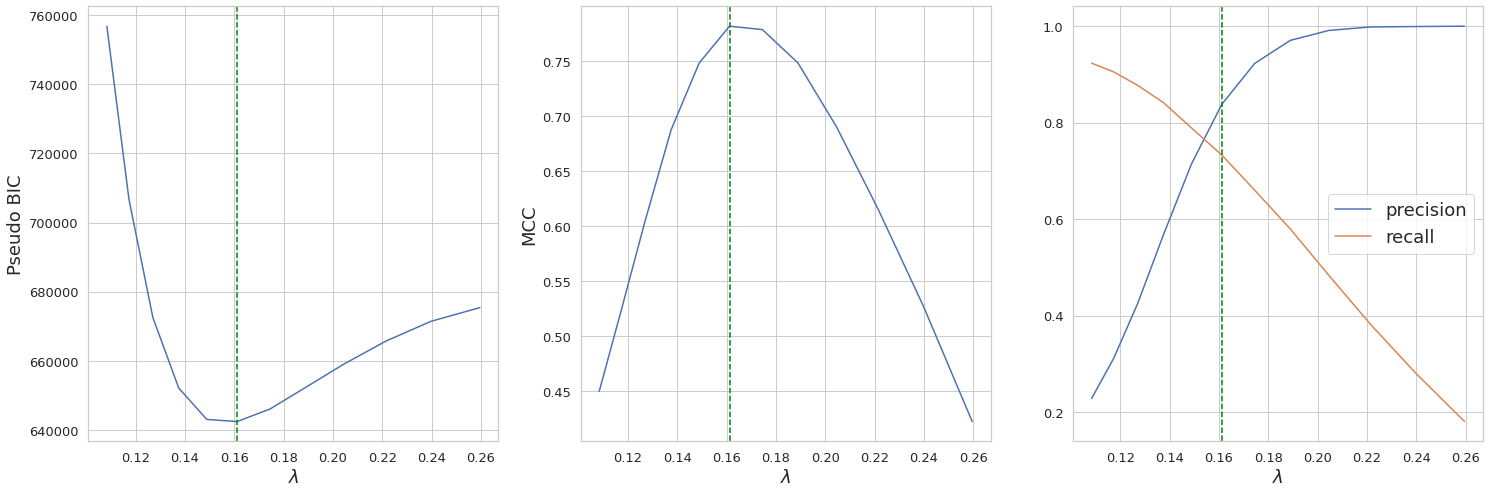

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
axes = axes.ravel()

i = 0
axes[i].plot(lams, pseudo_bics)
axes[i].axvline(best_lam, linestyle='--', color='green')
axes[i].set_xlabel('$\lambda$', fontsize=18)
axes[i].set_ylabel('Pseudo BIC', fontsize=18)
axes[i].tick_params(axis='both', which='major', labelsize=13)

i = 1
axes[i].plot(lams, mccs)
axes[i].axvline(best_lam, linestyle='--', color='green')
axes[i].set_xlabel('$\lambda$', fontsize=18)
axes[i].set_ylabel('MCC', fontsize=18)
axes[i].tick_params(axis='both', which='major', labelsize=13)

i = 2
axes[i].plot(lams, precs, label='precision')
axes[i].plot(lams, recalls, label='recall')
axes[i].axvline(best_lam, linestyle='--', color='green')
axes[i].set_xlabel('$\lambda$', fontsize=18)
axes[i].legend(fontsize=18)
axes[i].tick_params(axis='both', which='major', labelsize=13);

In [25]:
# fit with best lam
model = GraphicalAccord(Omega_star=np.eye(p), lam1=best_lam, lam2=0.0, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=500, penalize_diag=True)
model.fit(X)
Omega_hat = model.omega_.toarray()
Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))
Partial_corr_hat = partial_corr(Theta_hat)

# refit for debiasing
lam_mat = np.where(Theta_hat != 0, 0, 1000.0)
model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam_mat, lam2=0.0, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=500, penalize_diag=True)
model.fit(X)
Omega_hat_debiased = model.omega_.toarray()
Theta_hat_debiased = 0.5 * ((np.diag(np.diag(Omega_hat_debiased)) @ Omega_hat_debiased) + (Omega_hat_debiased.T @ np.diag(np.diag(Omega_hat_debiased))))
Partial_corr_hat_debiased = partial_corr(Theta_hat_debiased)

In [26]:
# set diagnoals to zero
np.fill_diagonal(Partial_corr, 0)
np.fill_diagonal(Partial_corr_hat, 0)
np.fill_diagonal(Partial_corr_hat_debiased, 0)

In [27]:
# get TP/FP indices
TP_indx_biased = np.intersect1d(np.flatnonzero(Partial_corr), np.flatnonzero(Partial_corr_hat))
FP_indx_biased = np.setdiff1d(np.flatnonzero(Partial_corr_hat), np.flatnonzero(Partial_corr))
FN_indx_biased = np.intersect1d(np.flatnonzero(Partial_corr), np.where(Partial_corr_hat.ravel() == 0)[0])
TN_indx_biased = np.intersect1d(np.where(Partial_corr.ravel() == 0)[0], np.where(Partial_corr_hat.ravel() == 0)[0])

TP_indx_debiased = np.intersect1d(np.flatnonzero(Partial_corr), np.flatnonzero(Partial_corr_hat_debiased))
FP_indx_debiased = np.setdiff1d(np.flatnonzero(Partial_corr_hat_debiased), np.flatnonzero(Partial_corr))
FN_indx_debiased = np.intersect1d(np.flatnonzero(Partial_corr), np.where(Partial_corr_hat_debiased.ravel() == 0)[0])
TN_indx_debiased = np.intersect1d(np.where(Partial_corr.ravel() == 0)[0], np.where(Partial_corr_hat_debiased.ravel() == 0)[0])

In [28]:
print(' - Biased Metrics')
print('Fro. Norm squared of TPs:', np.linalg.norm(Partial_corr.ravel()[TP_indx_biased] - Partial_corr_hat.ravel()[TP_indx_biased])**2)
print('Fro. Norm squared of FPs:', np.linalg.norm(Partial_corr.ravel()[FP_indx_biased] - Partial_corr_hat.ravel()[FP_indx_biased])**2)
print('Fro. Norm squared of total:', np.linalg.norm(Partial_corr - Partial_corr_hat)**2)
print(' ')
print('Average Fro. Norm squared of TPs:', (np.linalg.norm(Partial_corr.ravel()[TP_indx_biased] - Partial_corr_hat.ravel()[TP_indx_biased])**2)/len(TP_indx_biased))
print('Average Fro. Norm squared of FPs:', (np.linalg.norm(Partial_corr.ravel()[FP_indx_biased] - Partial_corr_hat.ravel()[FP_indx_biased])**2)/len(FP_indx_biased))
print('\n')

print(' - Debiased Metrics')
print('Fro. Norm squared of TPs:', np.linalg.norm(Partial_corr.ravel()[TP_indx_debiased] - Partial_corr_hat_debiased.ravel()[TP_indx_debiased])**2)
print('Fro. Norm squared of FPs:', np.linalg.norm(Partial_corr.ravel()[FP_indx_debiased] - Partial_corr_hat_debiased.ravel()[FP_indx_debiased])**2)
print('Fro. Norm squared of total:', np.linalg.norm(Partial_corr - Partial_corr_hat_debiased)**2)
print(' ')
print('Average Fro. Norm squared of TPs:', (np.linalg.norm(Partial_corr.ravel()[TP_indx_debiased] - Partial_corr_hat_debiased.ravel()[TP_indx_debiased])**2)/len(TP_indx_debiased))
print('Average Fro. Norm squared of FPs:', (np.linalg.norm(Partial_corr.ravel()[FP_indx_debiased] - Partial_corr_hat_debiased.ravel()[FP_indx_debiased])**2)/len(FP_indx_debiased))

 - Biased Metrics
Fro. Norm squared of TPs: 75.09983898816589
Fro. Norm squared of FPs: 0.16382838094449803
Fro. Norm squared of total: 110.08857873550492
 
Average Fro. Norm squared of TPs: 0.010465417919198144
Average Fro. Norm squared of FPs: 0.00011820229505375038


 - Debiased Metrics
Fro. Norm squared of TPs: 8.072466547605547
Fro. Norm squared of FPs: 17.70843855924051
Fro. Norm squared of total: 60.60581647324058
 
Average Fro. Norm squared of TPs: 0.001124925661594976
Average Fro. Norm squared of FPs: 0.012776651197143225


In [29]:
# get partial correlations for TP/FP
true_nonzeros = Partial_corr[Partial_corr != 0]

biased_nonzeros_TP = Partial_corr_hat.ravel()[TP_indx_biased]
biased_nonzeros_FP = Partial_corr_hat.ravel()[FP_indx_biased]

debiased_nonzeros_TP = Partial_corr_hat_debiased.ravel()[TP_indx_debiased]
debiased_nonzeros_FP = Partial_corr_hat_debiased.ravel()[FP_indx_debiased]

### Visualization (hub network)

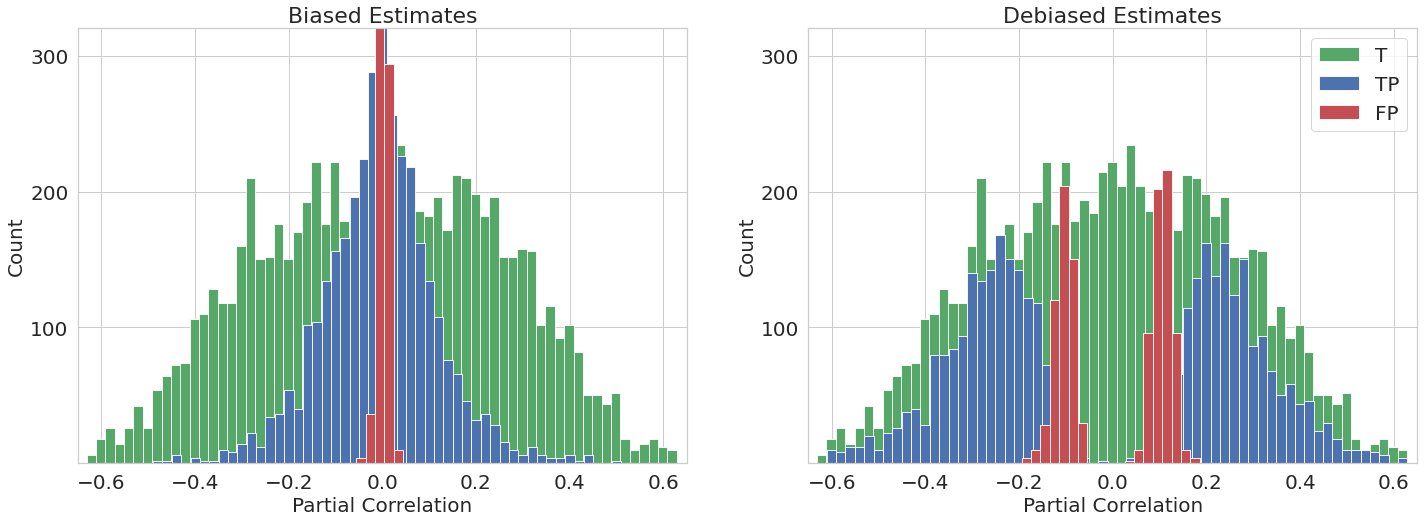

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
axes = axes.ravel()
binwidth=0.02

i = 0
sns.histplot(true_nonzeros, color=sns.color_palette()[2], binwidth=binwidth, alpha=1, label='T', ax=axes[i])
sns.histplot(biased_nonzeros_TP, color=sns.color_palette()[0], binwidth=binwidth, alpha=1, label='TP', ax=axes[i])
sns.histplot(biased_nonzeros_FP, color=sns.color_palette()[3], binwidth=binwidth, alpha=1, label='FP', ax=axes[i])
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_yticks([100, 200, 300, 400])
axes[i].set_title('Biased Estimates', fontsize=22)
axes[i].set_xlabel('Partial Correlation', fontsize=20)
axes[i].set_ylabel('Count', fontsize=20)
axes[i].set_xlim((-0.65,0.65))
axes[i].set_ylim((0,320))

i = 1
sns.histplot(true_nonzeros, color=sns.color_palette()[2], binwidth=binwidth, alpha=1, label='T', ax=axes[i])
sns.histplot(debiased_nonzeros_TP, color=sns.color_palette()[0], binwidth=binwidth, alpha=1, label='TP', ax=axes[i])
sns.histplot(debiased_nonzeros_FP, color=sns.color_palette()[3], binwidth=binwidth, alpha=1, label='FP', ax=axes[i])
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_yticks([100, 200, 300, 400])
axes[i].set_title('Debiased Estimates', fontsize=22)
axes[i].set_xlabel('Partial Correlation', fontsize=20)
axes[i].set_ylabel('Count', fontsize=20)
axes[i].set_xlim((-0.65,0.65))
axes[i].set_ylim((0,320))
axes[i].legend(fontsize=20)

plt.savefig('../output/debiasing-hub-network.png', bbox_inches='tight');

### Visualization (erdos-renyi)

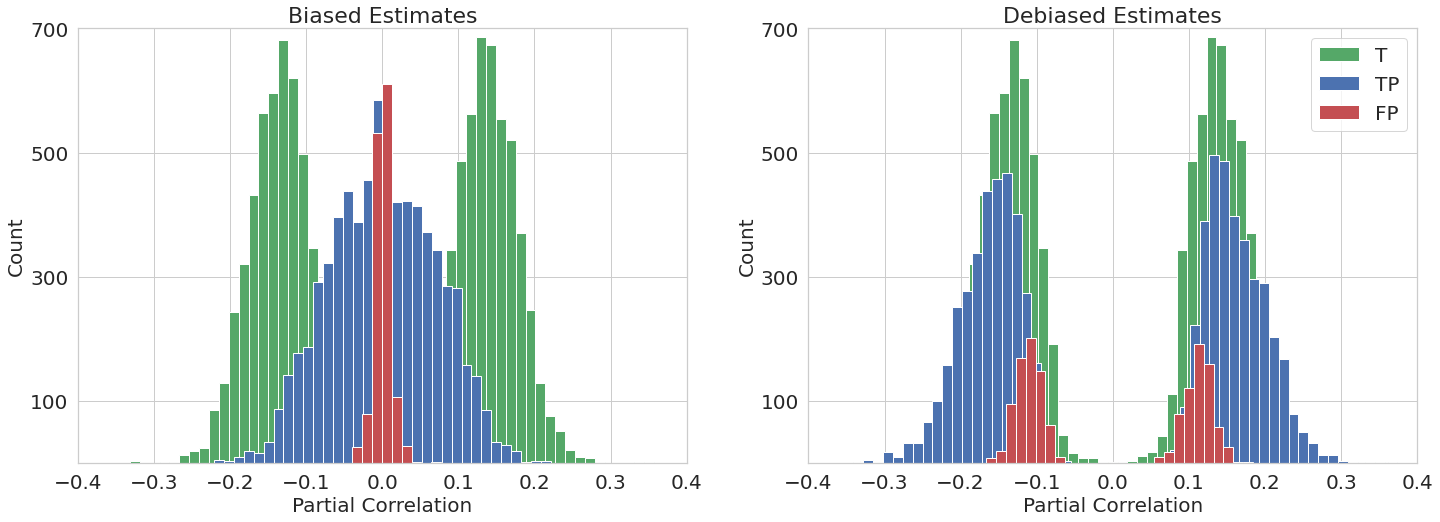

In [31]:
# erdos-renyi
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
axes = axes.ravel()
binwidth=0.013

i = 0
sns.histplot(true_nonzeros, color=sns.color_palette()[2], binwidth=binwidth, alpha=1, label='T', ax=axes[i])
sns.histplot(biased_nonzeros_TP, color=sns.color_palette()[0], binwidth=binwidth,  alpha=1, label='TP', ax=axes[i])
sns.histplot(biased_nonzeros_FP, color=sns.color_palette()[3], binwidth=binwidth, alpha=1, label='FP', ax=axes[i])
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_yticks([100, 300, 500, 700])
axes[i].set_title('Biased Estimates', fontsize=22)
axes[i].set_xlabel('Partial Correlation', fontsize=20)
axes[i].set_ylabel('Count', fontsize=20)
axes[i].set_xlim((-0.4,0.4))
axes[i].set_ylim((0,700))

i = 1
sns.histplot(true_nonzeros, color=sns.color_palette()[2], binwidth=binwidth, alpha=1, label='T', ax=axes[i])
sns.histplot(debiased_nonzeros_TP, color=sns.color_palette()[0], binwidth=binwidth, alpha=1, label='TP', ax=axes[i])
sns.histplot(debiased_nonzeros_FP, color=sns.color_palette()[3], binwidth=binwidth, alpha=1, label='FP', ax=axes[i])
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_yticks([100, 300, 500, 700])
axes[i].set_title('Debiased Estimates', fontsize=22)
axes[i].set_xlabel('Partial Correlation', fontsize=20)
axes[i].set_ylabel('Count', fontsize=20)
axes[i].set_xlim((-0.4,0.4))
axes[i].set_ylim((0,700))
axes[i].legend(fontsize=20)

plt.savefig('../output/debiasing-erdos-renyi.png', bbox_inches='tight');